In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [80]:
df_test_north = pd.read_csv('results/north.csv')
df_test_south = pd.read_csv('results/south.csv')
df_test_des = pd.read_csv('results/des.csv')




In [81]:
df_test_north.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,seeing_z,lrg_lin,elg_lin,qso_lin,lrg_deep,elg_deep,qso_deep,lrg_nn,elg_nn,qso_nn
count,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,...,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000
mean,92225.883773,35.255217,125.013074,153.388157,0.241988,0.138916,0.135081,0.191441,0.761007,0.621414,...,0.085140,35.296497,124.911223,153.147307,35.388543,125.247744,152.095823,35.742702,126.705088,152.847916
std,52431.908880,11.970088,22.396739,29.051528,0.117935,0.129989,0.129680,0.172791,0.097736,0.090272,...,0.035986,1.768797,8.975664,8.905784,1.779177,10.425933,10.782170,1.778805,9.304531,9.992797
min,1676.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000778,0.000739,0.005608,0.102406,...,0.009702,31.002243,67.929866,104.933991,24.518848,0.256241,36.049149,24.043634,0.000000,55.794102
25%,46904.000000,27.000000,111.000000,133.000000,0.181818,0.058577,0.049559,0.049132,0.717752,0.572679,...,0.062168,34.220784,120.715764,147.633220,34.251625,120.697037,142.851883,34.483624,121.840973,146.860291
50%,90608.000000,34.000000,124.000000,152.000000,0.209790,0.087866,0.083774,0.134943,0.777599,0.635442,...,0.080854,34.760544,125.847317,153.274758,34.927025,125.993736,150.651016,35.127621,127.080925,153.105423
75%,137175.000000,41.000000,139.000000,172.000000,0.244755,0.167364,0.177612,0.282249,0.829016,0.682651,...,0.102415,35.928599,130.295280,159.138528,36.255074,131.418030,161.891022,36.745148,131.961945,160.499496
max,186638.000000,131.000000,285.000000,314.000000,1.000000,0.979079,0.982179,0.775222,0.974139,1.000000,...,1.000000,44.207563,204.662816,194.513427,43.500221,179.823257,182.639252,42.653908,167.424225,179.188843


In [82]:
zscore = lambda x: abs((x - x.median()) / x.std())

df_test_north['ELG_Z_deep']  = df_test_north['elg'] - df_test_north['elg_deep']
df_test_north['ELG_Z_deep'] = df_test_north['ELG_Z_deep'].transform(zscore)
df_test_north['ELG_Z_nn']  = df_test_north['elg'] - df_test_north['elg_nn']
df_test_north['ELG_Z_nn'] = df_test_north['ELG_Z_deep'].transform(zscore)
df_test_north['ELG_Z_lin']  = df_test_north['elg'] - df_test_north['elg_lin']
df_test_north['ELG_Z_lin'] = df_test_north['ELG_Z_deep'].transform(zscore)



print(df_test_north['ELG_Z_deep'])

0        1.999433
1        1.287141
2        1.287255
3        1.245969
4        0.802212
           ...   
19500    0.303964
19501    0.091100
19502    0.255578
19503    1.319875
19504    0.566612
Name: ELG_Z_deep, Length: 19505, dtype: float64


In [85]:
df = df_test_north[df_test_north['ELG_Z_deep'] < 1]
df_diff = df[df['ELG_Z_lin'] > 1]
df_no_diff = df[df['ELG_Z_lin'] <= 1]

print(len(df_diff))
print(len(df_no_diff))



df_lala = df_diff.describe() - df_no_diff.describe()

df_lala.columns

130
13644


Index(['pixel_id', 'lrg', 'elg', 'qso', 'exposures', 'stellar', 'EBV',
       'airmass', 'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'exptime_g',
       'exptime_r', 'exptime_z', 'meansky_g', 'meansky_r', 'meansky_z',
       'seeing_g', 'seeing_r', 'seeing_z', 'lrg_lin', 'elg_lin', 'qso_lin',
       'lrg_deep', 'elg_deep', 'qso_deep', 'lrg_nn', 'elg_nn', 'qso_nn',
       'ELG_Z_deep', 'ELG_Z_nn', 'ELG_Z_lin'],
      dtype='object')

In [91]:
import math
from scipy.stats import t

n1, n2 = len(df_diff), len(df_no_diff)

for col in df_diff:
    m1 = df_diff[col].mean()
    m2 = df_no_diff[col].mean()
    std1 = df_diff[col].std()
    std2 = df_no_diff[col].std()

    se1, se2 = std1/math.sqrt(n1), std2/math.sqrt(n2)
    sed = math.sqrt(se1**2.0 + se2**2.0)
    t_stat = (m1 - m2) / sed

    dof = n1 + n2 - 2

    cv = t.ppf(1.0 - 0.05, dof)
    p = (1.0 - t.cdf(abs(t_stat), dof)) * 2.0


    print(col, p)
    print()


pixel_id 0.47439605286094544

lrg 0.8519173259927841

elg 0.15322685259692737

qso 0.7728603220851189

exposures 0.5742314960940367

stellar 0.775924482044789

EBV 0.8095553676297245

airmass 0.8465999007546925

ccdskysb_g 0.49161620894575186

ccdskysb_r 0.9183648964347817

ccdskysb_z 0.3470660429292436

exptime_g 0.2967371446156517

exptime_r 0.9128311722159879

exptime_z 0.6566528821874935

meansky_g 0.3701680670227332

meansky_r 0.6806541947366755

meansky_z 0.4568683398623423

seeing_g 0.1930330749770217

seeing_r 0.20530088228376853

seeing_z 0.8706257030833475

lrg_lin 0.7644576634787068

elg_lin 0.543253676452133

qso_lin 0.10243600263404007

lrg_deep 0.5688579876209978

elg_deep 0.3078418666406655

qso_deep 0.6179853798154906

lrg_nn 0.6566642324931875

elg_nn 0.21703288506690366

qso_nn 0.2688212624556763

ELG_Z_deep 0.0

ELG_Z_nn 0.0

ELG_Z_lin 0.0



In [ ]:
df_test_north["sig_Z_lin"] = df_test_north['ELG_Z_deep'] - df_test_north['ELG_Z_lin']
df_test_north["sig_Z_lin"] = df_test_north['sig_Z_lin'].transform(zscore)

df_no_diff = df_test_north[df_test_north['sig_Z_lin'] <= 1]
df_diff = df_test_north[df_test_north['sig_Z_lin'] > 1]
print(len(df_test_north), len(df_diff) + len(df_no_diff))

In [50]:
print(df_diff.describe())

            pixel_id          lrg          elg          qso    exposures  \
count    4885.000000  4885.000000  4885.000000  4885.000000  4885.000000   
mean    92165.712794    35.375844   126.259365   153.817810     0.240776   
std     52167.657230    12.177939    21.545375    30.286564     0.119636   
min      1782.000000     1.000000     1.000000     1.000000     0.000000   
25%     47383.000000    28.000000   119.000000   134.000000     0.181818   
50%     90582.000000    34.000000   125.000000   153.000000     0.209790   
75%    137120.000000    41.000000   131.000000   172.000000     0.244755   
max    186601.000000   131.000000   285.000000   284.000000     1.000000   

           stellar          EBV      airmass   ccdskysb_g   ccdskysb_r  ...  \
count  4885.000000  4885.000000  4885.000000  4885.000000  4885.000000  ...   
mean      0.140166     0.135833     0.190316     0.763017     0.622423  ...   
std       0.132053     0.132835     0.171993     0.096507     0.091726  ...   

In [51]:
print(df_no_diff.describe())

            pixel_id           lrg           elg           qso     exposures  \
count   14620.000000  14620.000000  14620.000000  14620.000000  14620.000000   
mean    92245.988782     35.214911    124.596648    153.244596      0.242393   
std     52521.670184     11.899977     22.659527     28.626620      0.117363   
min      1676.000000      1.000000      1.000000      2.000000      0.013986   
25%     46835.500000     27.000000    108.000000    133.000000      0.181818   
50%     90623.500000     34.000000    123.000000    152.000000      0.209790   
75%    137194.000000     41.000000    142.000000    171.000000      0.244755   
max    186638.000000    131.000000    205.000000    314.000000      0.986014   

            stellar           EBV       airmass    ccdskysb_g    ccdskysb_r  \
count  14620.000000  14620.000000  14620.000000  14620.000000  14620.000000   
mean       0.138498      0.134830      0.191817      0.760335      0.621077   
std        0.129294      0.128613      0.1

In [53]:

df_lala = (df_diff.describe() - df_no_diff.describe())

print(df_lala.columns)

          pixel_id          lrg          elg          qso    exposures  \
count -9735.000000 -9735.000000 -9735.000000 -9735.000000 -9735.000000   
mean    -80.275988     0.160933     1.662717     0.573213    -0.001618   
std    -354.012955     0.277962    -1.114152     1.659944     0.002273   
min     106.000000     0.000000     0.000000    -1.000000    -0.013986   
25%     547.500000     1.000000    11.000000     1.000000     0.000000   
50%     -41.500000     0.000000     2.000000     1.000000     0.000000   
75%     -74.000000     0.000000   -11.000000     1.000000     0.000000   
max     -37.000000     0.000000    80.000000   -30.000000     0.013986   

           stellar          EBV      airmass   ccdskysb_g   ccdskysb_r  ...  \
count -9735.000000 -9735.000000 -9735.000000 -9735.000000 -9735.000000  ...   
mean      0.001668     0.001004    -0.001501     0.002681     0.001347  ...   
std       0.002760     0.004223    -0.001069    -0.001630     0.001945  ...   
min       0.00000

In [61]:
y_gold = df_diff.elg
y_pred = df_diff.elg_deep
print(f"Deep Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_diff.elg
y_pred = df_diff.elg_lin
print(f"Linear Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_diff.elg
y_pred = df_diff.elg_nn
print(f"NN Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")

Deep Regression R^2:  0.27565992568107933.

Linear Regression R^2:  0.158660999385435.

NN Regression R^2:  0.24114887869003987.


In [62]:
y_gold = df_no_diff.elg
y_pred = df_no_diff.elg_deep
print(f"Deep Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_no_diff.elg
y_pred = df_no_diff.elg_lin
print(f"Linear Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_no_diff.elg
y_pred = df_no_diff.elg_nn
print(f"NN Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")



Deep Regression R^2:  0.2762591695325983.

Linear Regression R^2:  0.16509796728029658.

NN Regression R^2:  0.19552599990203445.


## Plotting the differences between the networks

#### TODO: For all 3 areas all 3 types, compare 3 models --> 27 plots:



In [7]:
from desiutil.plots import plot_sky_binned
import healpy as hp

NSIDE = 256



In [3]:

df_test_north = pd.read_csv('results/north_complete.csv')
df_test_south = pd.read_csv('results/south_complete.csv')
df_test_des = pd.read_csv('results/des_complete.csv')
df_test_north.drop(columns=['y_gold_y', 'y_gold_x', 'y_gold'], inplace=True)
df_test_south.drop(columns=['y_gold_y', 'y_gold_x', 'y_gold'], inplace=True)
df_test_des.drop(columns=['y_gold_y', 'y_gold_x', 'y_gold'], inplace=True)


In [4]:
df_test_north.columns

Index(['pixel_id', 'lrg', 'elg', 'qso', 'exposures', 'stellar', 'EBV',
       'airmass', 'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'exptime_g',
       'exptime_r', 'exptime_z', 'meansky_g', 'meansky_r', 'meansky_z',
       'seeing_g', 'seeing_r', 'seeing_z', 'lrg_lin', 'elg_lin', 'qso_lin',
       'lrg_nn', 'elg_nn', 'qso_nn', 'lrg_deep', 'elg_deep', 'qso_deep'],
      dtype='object')

In [178]:
area = 'north'
gal = 'elg'

df_test = pd.read_csv(f'results/{area}_complete.csv')


In [179]:
df_test[f'{gal}_LINEAR_VS_NN'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_nn']
df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']
df_test[f'{gal}_NN_VS_DEEP'] = df_test[f'{gal}_nn'] - df_test[f'{gal}_deep']

df_test[f'{gal}_GOLD_VS_LINEAR'] = df_test[f'{gal}'] - df_test[f'{gal}_lin']
df_test[f'{gal}_GOLD_VS_NN'] = df_test[f'{gal}'] - df_test[f'{gal}_nn']
df_test[f'{gal}_GOLD_VS_DEEP'] = df_test[f'{gal}'] - df_test[f'{gal}_deep']


df_test.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,elg_deep,y_gold_y,qso_deep,y_gold,elg_LINEAR_VS_NN,elg_LINEAR_VS_DEEP,elg_NN_VS_DEEP,elg_GOLD_VS_LINEAR,elg_GOLD_VS_NN,elg_GOLD_VS_DEEP
count,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,...,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000,97512.000000
mean,92727.060372,35.284242,124.994093,153.217953,0.241254,0.138893,0.133994,0.189980,0.760625,0.621835,...,125.250448,124.994093,151.974754,153.217953,-1.782413,-0.270696,1.511717,0.014341,-1.768072,-0.256355
std,52362.454442,11.989440,22.236808,28.685116,0.116953,0.130899,0.127760,0.173179,0.097261,0.090132,...,10.721035,22.236808,10.901988,28.685116,4.204162,7.822170,6.649239,20.358023,19.679929,18.433627
min,1672.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-16.683737,1.000000,33.930271,1.000000,-35.386391,-92.345403,-80.283981,-135.643607,-133.543610,-139.882019
25%,47548.750000,27.000000,111.000000,134.000000,0.181818,0.058577,0.049275,0.048089,0.717936,0.574291,...,120.748043,111.000000,142.898087,134.000000,-3.466811,-4.318875,-2.143982,-13.214876,-14.795589,-12.616222
50%,91531.500000,34.000000,125.000000,152.000000,0.209790,0.087866,0.083369,0.133068,0.777146,0.635936,...,126.001419,125.000000,150.590439,152.000000,-1.614161,-0.469157,1.250626,-0.682971,-2.553955,-0.961807
75%,137463.250000,41.000000,139.000000,171.000000,0.244755,0.167364,0.177345,0.279442,0.828575,0.682960,...,131.360260,139.000000,161.701023,171.000000,-0.162494,3.424898,4.820124,12.464521,10.383801,11.187300
max,186645.000000,131.000000,285.000000,334.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,191.120193,285.000000,185.263977,334.000000,118.454740,129.438586,100.571295,162.100261,153.019302,153.111877


Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


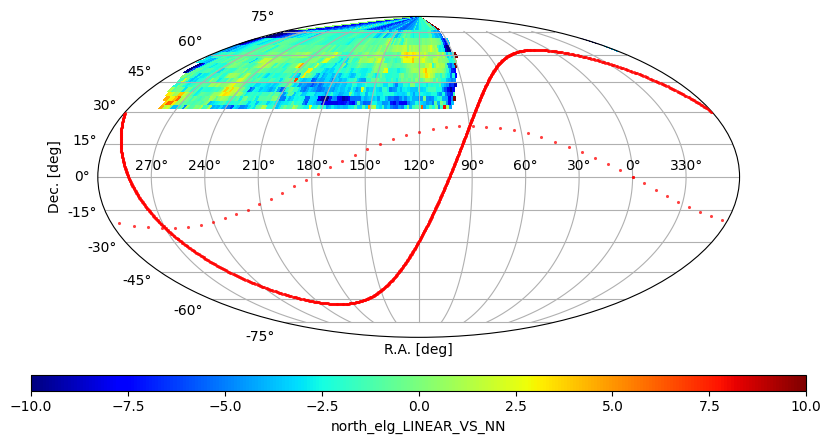

In [180]:
bin_area = 3
ra, dec = hp.pix2ang(NSIDE, df_test.pixel_id,lonlat=True)
clipper = 10
ax1 = plot_sky_binned(ra,dec,data=df_test[f'{gal}_LINEAR_VS_NN'] ,cmap='jet',label=f'{area}_{gal}_LINEAR_VS_NN', plot_type='grid', verbose=True,max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


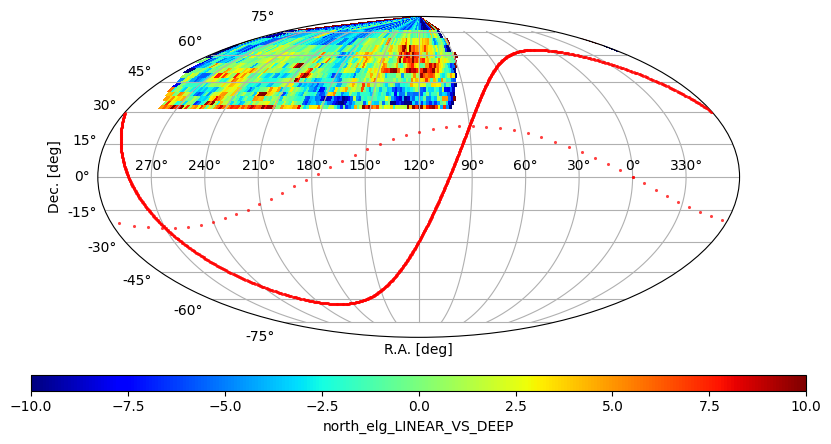

In [181]:
ax2 = plot_sky_binned(ra,dec,data=df_test[f'{gal}_LINEAR_VS_DEEP'] ,cmap='jet',label=f'{area}_{gal}_LINEAR_VS_DEEP', plot_type='grid', verbose=True,max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


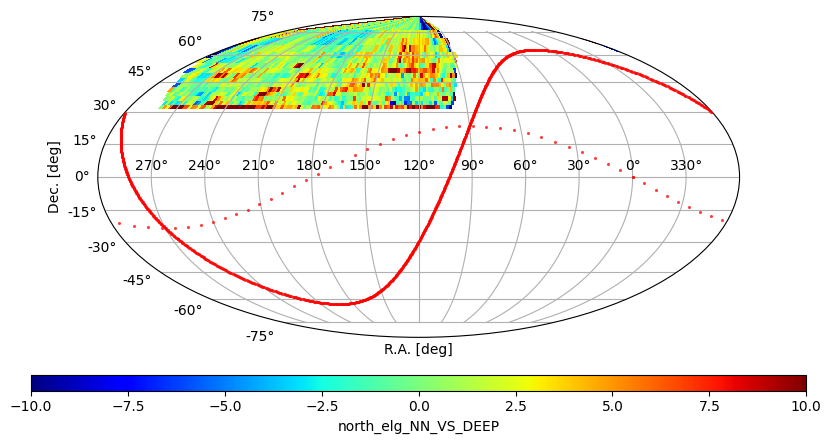

In [182]:
ax3 = plot_sky_binned(ra,dec,data=df_test[f'{gal}_NN_VS_DEEP'] ,cmap='jet',label=f'{area}_{gal}_NN_VS_DEEP', plot_type='grid', verbose=True,max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

clipper = 20

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


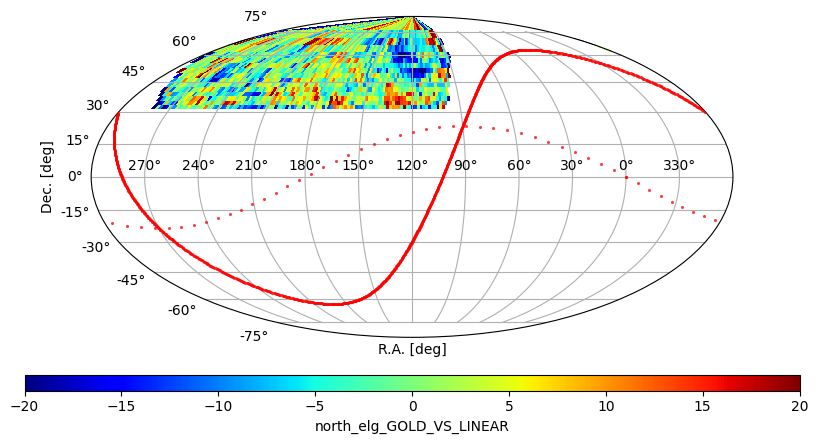

In [183]:
ax4 = plot_sky_binned(ra,dec,data=df_test[f'{gal}_GOLD_VS_LINEAR'] ,cmap='jet',label=f'{area}_{gal}_GOLD_VS_LINEAR', plot_type='grid', verbose=True,max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


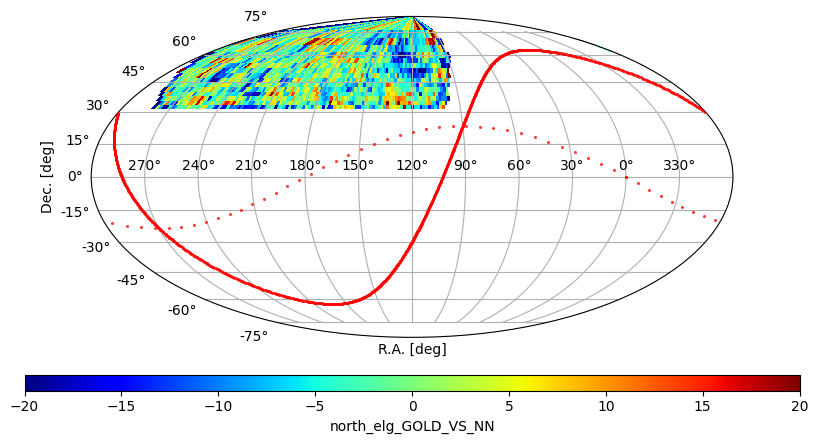

In [184]:
ax5 = plot_sky_binned(ra,dec,data=df_test[f'{gal}_GOLD_VS_NN'] ,cmap='jet',label=f'{area}_{gal}_GOLD_VS_NN', plot_type='grid', verbose=True,max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


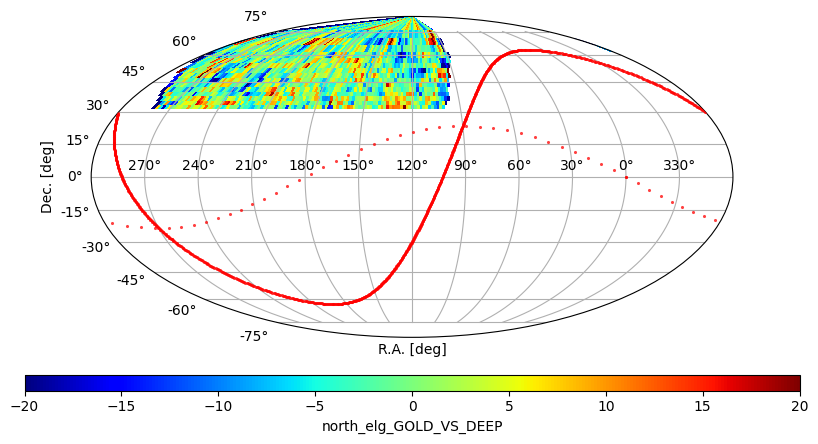

In [185]:
ax6 = plot_sky_binned(ra,dec,data=df_test[f'{gal}_GOLD_VS_DEEP'] ,cmap='jet',label=f'{area}_{gal}_GOLD_VS_DEEP', plot_type='grid', verbose=True,max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)